In [52]:
import os
import numpy as np
import torch
from PIL import Image
import requests
from transformers import SamModel, SamProcessor
import matplotlib.pyplot as plt
%matplotlib inline

from util import *

In [2]:
cache_dir = "./cache" # path to the cache directory

# create the cache directory if it doesn't exist
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SamModel.from_pretrained("facebook/sam-vit-huge", cache_dir=cache_dir).to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge", cache_dir=cache_dir)

Image size: (640, 480)


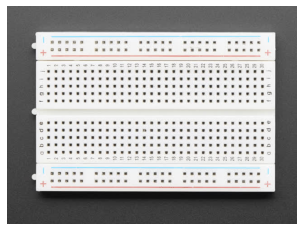

In [16]:
img_path = "images/breadboard_plain.jpeg"
raw_image = Image.open(img_path).convert("RGB")

# print image size
print("Image size: {}".format(raw_image.size))

# display the image
plt.imshow(raw_image)
plt.axis("off")
plt.show()

# coordinates are (67, 62) and (590, 407)
inputs = processor(raw_image, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])

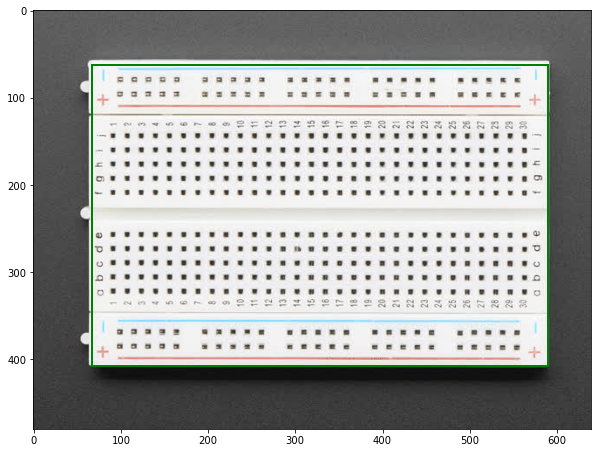

In [17]:
input_boxes = [[67, 62, 590, 407]]
show_boxes_on_image(raw_image, input_boxes)

In [18]:
inputs = processor(raw_image, input_boxes=input_boxes, return_tensors="pt").to(device)
inputs["input_boxes"].shape

torch.Size([1, 1, 4])

In [27]:
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

tensor([[[0.7796, 0.9855, 1.0102]]])


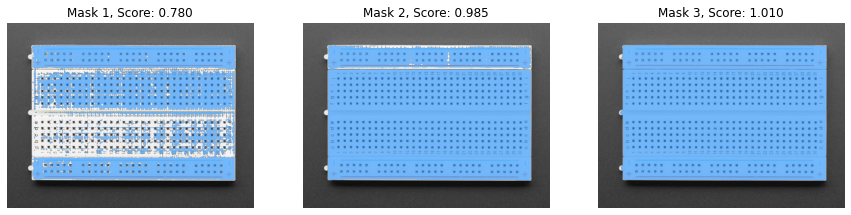

In [53]:
print(scores)
show_masks_on_image(raw_image, masks[0], scores)

In [51]:
print(masks[0].shape)
print(scores.shape)

# display the coordinates of the mask with the highest score
print("Coordinates of the mask with the highest score: {}".format(masks[0][-1].nonzero()))

torch.Size([1, 3, 480, 640])
torch.Size([1, 1, 3])
Coordinates of the mask with the highest score: tensor([[  0,  58,  70],
        [  0,  58,  71],
        [  0,  58,  72],
        ...,
        [  2, 408, 581],
        [  2, 408, 582],
        [  2, 408, 585]])
